In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, hour, when
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

2023-09-22 18:18:33.574404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-22 18:18:33.574462: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
spark = SparkSession.builder.appName("DataModeling").getOrCreate()

In [3]:
# Read the Parquet file into a DataFrame
df = spark.read.parquet("/user1/data/parquet/*.parquet")

In [4]:
df.show(2, truncate=False)

+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+
|square_id|timestamp          |country_code|internet_traffic_activity|hourly_timestamp   |SMS_activity      |call_activity      |weekend_or_weekday|
+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+
|1        |2013-10-31 23:00:00|39          |11.028366381681026       |2013-10-31 23:00:00|0.2986512597414538|0.2132127854455914 |weekday           |
|1        |2013-10-31 23:10:00|39          |11.100963451409388       |2013-10-31 23:00:00|0.3983777976024016|0.32241464495433614|weekday           |
+---------+-------------------+------------+-------------------------+-------------------+------------------+-------------------+------------------+
only showing top 2 rows



In [5]:
df.printSchema()

root
 |-- square_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday: string (nullable = true)



In [6]:
df.count()

7516761

In [7]:
print('Count of distinct rows: {0}'.format(df.distinct().count())) #duplicates

Count of distinct rows: 7516761


In [8]:
df.groupby('country_code').count().sort('count').show(30)

+------------+-------+
|country_code|  count|
+------------+-------+
|          45|      1|
|          40|      1|
|         966|      2|
|         421|      2|
|         353|      3|
|         385|      3|
|          61|      4|
|          31|      4|
|         356|      5|
|          90|      6|
|         386|      7|
|         351|      9|
|          43|     14|
|          32|     15|
|         358|     21|
|           0|     21|
|         213|     23|
|          47|     42|
|          34|     68|
|           1|     91|
|         420|     93|
|          48|     98|
|          49|    151|
|          46|    218|
|           7|    496|
|          86|   1054|
|          44|   1197|
|          33|   1298|
|          41|   1353|
|          39|7510461|
+------------+-------+



In [9]:
# numerical stat
df.describe(['internet_traffic_activity', 'SMS_activity', 'call_activity']).show()

+-------+-------------------------+--------------------+--------------------+
|summary|internet_traffic_activity|        SMS_activity|       call_activity|
+-------+-------------------------+--------------------+--------------------+
|  count|                  7516761|             7516761|             7516761|
|   mean|        81.02824368179743|   7.151377454212734|    8.21545912479918|
| stddev|       143.69671563945369|  14.738696897264143|  16.946580289458204|
|    min|     4.792346910579604E-5|1.235047397115846...|4.662995399058662E-6|
|    max|        7936.265379884158|   1211.443277333027|   532.5074148119132|
+-------+-------------------------+--------------------+--------------------+



In [10]:
from pyspark.sql.functions import col

df = df.withColumn("square_id", col("square_id").cast("integer"))

In [11]:
# correlation
features = ['square_id', 'internet_traffic_activity', 'SMS_activity', 'call_activity']
n = len(features)

corr = []

for i in range(0, n):
    temp = [None]*i
    
    for j in range(i, n):
        temp.append(df.corr(features[i], features[j]))
    corr.append(temp)
    
corr

[[1.0, 0.1415706480958958, 0.12647822181687138, 0.12565426847843997],
 [None, 1.0, 0.8789476193973431, 0.8444776822637831],
 [None, None, 1.0, 0.8929825876389413],
 [None, None, None, 1.0]]

In [12]:
# transform timestamp into categorical values
from pyspark.sql.functions import hour
from pyspark.sql.functions import udf

df = df.withColumn('hour_of_day', hour(df.timestamp))

def categorize_hour(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 15:
        return 'lunch'
    elif 15 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'
    
# Apply the UDF to create a new column with categorical values
categorize_hour_udf = udf(categorize_hour)
df = df.withColumn('time_of_day', categorize_hour_udf(df.hour_of_day))

# Show the transformed DataFrame
df.show()

+---------+-------------------+------------+-------------------------+-------------------+--------------------+--------------------+------------------+-----------+-----------+
|square_id|          timestamp|country_code|internet_traffic_activity|   hourly_timestamp|        SMS_activity|       call_activity|weekend_or_weekday|hour_of_day|time_of_day|
+---------+-------------------+------------+-------------------------+-------------------+--------------------+--------------------+------------------+-----------+-----------+
|        1|2013-10-31 23:00:00|          39|       11.028366381681026|2013-10-31 23:00:00|  0.2986512597414538|  0.2132127854455914|           weekday|         23|      night|
|        1|2013-10-31 23:10:00|          39|       11.100963451409388|2013-10-31 23:00:00|  0.3983777976024016| 0.32241464495433614|           weekday|         23|      night|
|        1|2013-10-31 23:20:00|          39|       10.892770602791096|2013-10-31 23:00:00|  0.5015934573020482|  0.18877

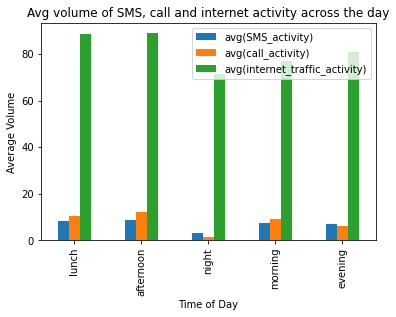

In [13]:
# Group the data by time_of_day and aggregate the average of each activity
activity_by_time_of_day = df.groupBy('time_of_day').agg({'SMS_activity': 'avg', 'call_activity': 'avg', 'internet_traffic_activity': 'avg'})

# Convert the DataFrame to a Pandas DataFrame for plotting
activity_by_time_of_day_pd = activity_by_time_of_day.toPandas()

# Plot the average volume of each activity per time_of_day
activity_by_time_of_day_pd.plot(kind='bar', x='time_of_day', y=['avg(SMS_activity)', 'avg(call_activity)', 'avg(internet_traffic_activity)'])
plt.title('Avg volume of SMS, call and internet activity across the day')
plt.xlabel('Time of Day')
plt.ylabel('Average Volume')
plt.show()

In [14]:
#preparing for modeling (cat values, scaling, splitting)
# handle categorical values

from pyspark.ml.feature import StringIndexer,OneHotEncoder

indexer1 = StringIndexer(inputCol='weekend_or_weekday', outputCol='weekend_or_weekday_index')
indexed1 = indexer1.fit(df).transform(df)

indexer2 = StringIndexer(inputCol='time_of_day', outputCol='time_of_day_index')
indexed2 = indexer2.fit(indexed1).transform(indexed1)

encoder = OneHotEncoder(inputCols=['weekend_or_weekday_index', 'time_of_day_index'], outputCols=['weekend_or_weekday_encoded', 'time_of_day_encoded'])
encoded = encoder.fit(indexed2).transform(indexed2)

encoded.show()

+---------+-------------------+------------+-------------------------+-------------------+--------------------+--------------------+------------------+-----------+-----------+------------------------+-----------------+--------------------------+-------------------+
|square_id|          timestamp|country_code|internet_traffic_activity|   hourly_timestamp|        SMS_activity|       call_activity|weekend_or_weekday|hour_of_day|time_of_day|weekend_or_weekday_index|time_of_day_index|weekend_or_weekday_encoded|time_of_day_encoded|
+---------+-------------------+------------+-------------------------+-------------------+--------------------+--------------------+------------------+-----------+-----------+------------------------+-----------------+--------------------------+-------------------+
|        1|2013-10-31 23:00:00|          39|       11.028366381681026|2013-10-31 23:00:00|  0.2986512597414538|  0.2132127854455914|           weekday|         23|      night|                     0.0|  

In [15]:
# dropping values not needed for the model
encoded.printSchema()

root
 |-- square_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday: string (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- weekend_or_weekday_index: double (nullable = false)
 |-- time_of_day_index: double (nullable = false)
 |-- weekend_or_weekday_encoded: vector (nullable = true)
 |-- time_of_day_encoded: vector (nullable = true)



In [16]:
encoded = encoded.drop('timestamp', 'hour_of_day', 'time_of_day', 'weekend_or_weekday', 'weekend_or_weekday_index', 'time_of_day_index', 'hourly_timestamp')

In [17]:
encoded.printSchema()

root
 |-- square_id: integer (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday_encoded: vector (nullable = true)
 |-- time_of_day_encoded: vector (nullable = true)



In [19]:
# normalization or scaling

In [20]:
internet = df.select(['internet_traffic_activity']).toPandas()

/home/hduser/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hduser/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


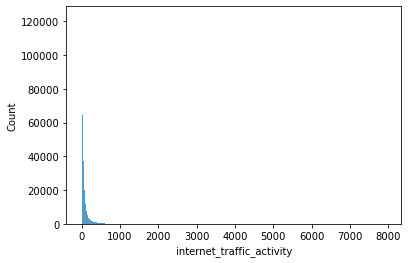

In [37]:
sns.histplot(internet['internet_traffic_activity']);

In [40]:
from pyspark.sql.functions import skewness

skewness_value = df.agg(skewness('SMS_activity')).collect()[0][0]
print(f"The skewness of the 'SMS_activity' column is: {skewness_value}")

The skewness of the 'SMS_activity' column is: 7.866375062955847


In [41]:
skewness_value = df.agg(skewness('call_activity')).collect()[0][0]
print(f"The skewness of the 'call_activity' column is: {skewness_value}")

The skewness of the 'call_activity' column is: 6.846711937178775


In [68]:
from pyspark.ml.feature import VectorAssembler, Normalizer

In [69]:
assembler = VectorAssembler(inputCols=encoded.columns, outputCol="features")
output = assembler.transform(encoded)

In [70]:
normalizer = Normalizer(inputCol="features", outputCol="normalizedFeatures", p=2.0)
normalizedData = normalizer.transform(output)

In [71]:
normalized = normalizedData.select("normalizedFeatures")

In [72]:
normalized.columns

['normalizedFeatures']

In [76]:
# TODO: normalize properly

In [81]:
# Prepare the data for training the autoencoder
X_train = encoded.select("*")  # "*" to take all input features
rdd = X_train.rdd
input_dim = len(X_train.columns)

In [82]:
# Define a function to train the autoencoder model on each partition
def train_autoencoder(partition):

    # Create a new autoencoder model for each partition
    autoencoder = Sequential([
        Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
        Dense(input_dim, activation='sigmoid')
    ])

    # Compile and fit the autoencoder model on the partition data
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(partition, partition, epochs=10, batch_size=32)

# Train the autoencoder model on each partition of the RDD
rdd.foreachPartition(train_autoencoder)

# Detect anomalies using the trained autoencoder
reconstructed_data = autoencoder.predict(X_train)
mse = tf.keras.losses.mean_squared_error(X_train, reconstructed_data)
anomaly_threshold = mse.mean() + mse.std() * 2  # Adjust the threshold as per your requirements

anomalies = X_train[mse > anomaly_threshold]

2023-09-22 19:32:21.231793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-22 19:32:21.231843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-22 19:32:21.240557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-22 19:32:21.257970: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-22 19:32:37.350052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 63.0 failed 1 times, most recent failure: Lost task 0.0 in stage 63.0 (TID 77) (10.0.2.15 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 609, in process
    out_iter = func(split_index, iterator)
  File "/usr/local/spark/python/pyspark/rdd.py", line -1, in pipeline_func
  File "/usr/local/spark/python/pyspark/rdd.py", line -1, in pipeline_func
  File "/usr/local/spark/python/pyspark/rdd.py", line -1, in pipeline_func
  File "/usr/local/spark/python/pyspark/rdd.py", line 614, in func
    rand.shuffle(samples)
  File "/usr/local/spark/python/pyspark/rdd.py", line 934, in func
    try:
  File "/tmp/ipykernel_5570/2145153841.py", line -1, in train_autoencoder
  File "/home/hduser/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/hduser/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 790, in __init__
    raise ValueError("`y` argument is not supported when using "
ValueError: `y` argument is not supported when using python generator as input.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:556)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:762)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:744)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:509)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1491)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2450)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2399)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2398)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2398)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1156)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2638)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2580)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2569)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2224)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2245)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2264)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2289)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 609, in process
    out_iter = func(split_index, iterator)
  File "/usr/local/spark/python/pyspark/rdd.py", line -1, in pipeline_func
  File "/usr/local/spark/python/pyspark/rdd.py", line -1, in pipeline_func
  File "/usr/local/spark/python/pyspark/rdd.py", line -1, in pipeline_func
  File "/usr/local/spark/python/pyspark/rdd.py", line 614, in func
    rand.shuffle(samples)
  File "/usr/local/spark/python/pyspark/rdd.py", line 934, in func
    try:
  File "/tmp/ipykernel_5570/2145153841.py", line -1, in train_autoencoder
  File "/home/hduser/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/hduser/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 790, in __init__
    raise ValueError("`y` argument is not supported when using "
ValueError: `y` argument is not supported when using python generator as input.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:556)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:762)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:744)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:509)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1491)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
